In [1]:
import numpy as np
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt

In [2]:
sigma   = 3.405
epsilon = 119.8*8.616733e-5 # eV
unit_cell_side = 5.269
cell_side = 6*unit_cell_side


In [3]:
def g_step(box, n_bin, d):
    box    += 1
    box    *= np.sqrt(2)/sigma
    del_bin = box/n_bin  #width of a bin
    
    g    = np.zeros([n_bin,n_bin])
    g[0] = np.linspace(0,box,n_bin)
    g[0]+= del_bin*0.5
    
    for i in range(len(d)):
        for j in range(i+1,len(d)):
            g_index = d[i][j]/(del_bin)
            #g_index = (d[i][j]-box*round(d[i][j]/box))/(del_bin)
            g[1,g_index.astype(int)] += 2
            # we count both for i and j.
            
    
    #nomalized by number of particles
    g[1] /= len(d[0])
    #and by bin volume
    
    for k in range(len(g[1])):
        g[1][k] /= ((k+1)**3 -k**3)*del_bin**3
        
    #side of the optimized cell: 5,269
    vol = (unit_cell_side/sigma)**3
    rho = 4./vol
    g[1] /= np.pi*(4/3)*rho
    return g;

### 20 K

In [4]:
trajectory = read('production_bulk_20-pos-1.xyz', index='::2')
N = len(trajectory[0])    #number of atoms
n_step = len(trajectory)  #number of step

#create a distance array
dist = np.empty([0,N,N])
for frame in trajectory:
    frame.set_cell([cell_side,cell_side,cell_side])
    frame.set_pbc((True,True,True))
    dist = np.append(dist, [frame.get_all_distances(mic=True)],axis=0)
    

#Lennard Jones units

dist  /= sigma

Text(0,0.5,'radial distribution function')

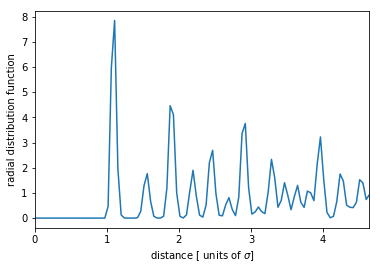

In [5]:
n_bin = 300  #number of bin in the graph
box   = cell_side   #side of the bon in the simulation 
g_20  = np.zeros([n_bin,n_bin])

#average during the thermalized part of the simulation
for i in range(n_step):
    g_20 += g_step(box,n_bin,dist[i])
g_20 /= n_step

plt.plot(g_20[0],g_20[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')

# 400 K


In [6]:
trajectory = read('production_bulk_400-pos-1.xyz', index='::2')
N = len(trajectory[0])    #number of atoms

n_step = len(trajectory)  #number of step
n_step
#create a distance array
dist = np.empty([0,N,N])
for frame in trajectory:
    frame.set_cell([cell_side,cell_side,cell_side])
    frame.set_pbc((True,True,True))
    dist = np.append(dist, [frame.get_all_distances(mic=True)],axis=0)

#Lennard Jones units

dist  /= sigma


Text(0,0.5,'radial distribution function')

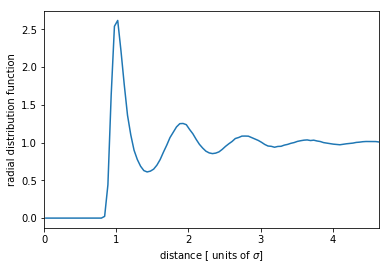

In [7]:


n_bin  = 300  #number of bin in the graph
box    = cell_side #side of the simulation box
g_400  = np.zeros([n_bin,n_bin])

#average during the thermalized part of the simulation
for i in range(n_step):
    g_400 += g_step(box,n_bin,dist[i])
g_400 /= n_step

plt.plot(g_400[0],g_400[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')
#plt.savefig("gr.png",  dpi=300,transparent=True)

# Comparison

Text(0,0.5,'radial distribution function')

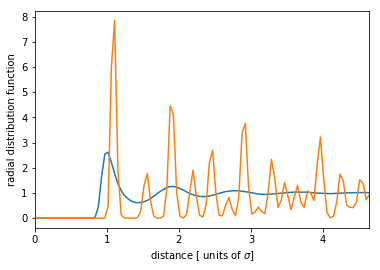

In [8]:
plt.plot(g_400[0],g_400[1])
plt.plot(g_20[0],g_20[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')


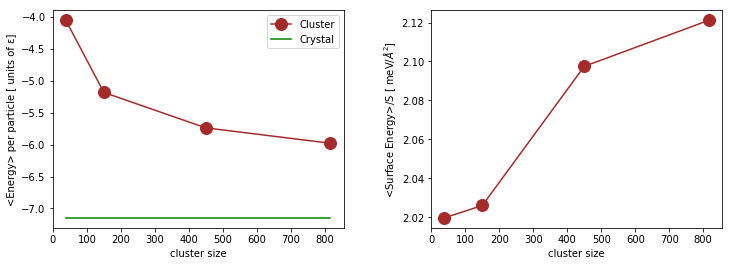

In [9]:
data38  = np.loadtxt('production_38-1.ener' )
data150 = np.loadtxt('production_150-1.ener')
data450 = np.loadtxt('production_450-1.ener')
data817 = np.loadtxt('production_817-1.ener')
dataBulk = np.loadtxt('production_bulk_20-1.ener')

data38   = np.transpose(data38)
data150  = np.transpose(data150)
data450  = np.transpose(data450)
data817  = np.transpose(data817)
dataBulk = np.transpose(dataBulk)


#energy in simulation time in LJ units
E38   = 27.1442*data38[4]/epsilon #eV / epsilon(eV)
E150  = 27.1442*data150[4]/epsilon 
E450  = 27.1442*data450[4]/epsilon 
E817  = 27.1442*data817[4]/epsilon 
EBulk = 27.1442*dataBulk[4]/epsilon 

#compute average energy 
e_average    = np.zeros([2,4])
e_average[0] = [38,150,450,817]
e_average[1] = [np.mean(E38),np.mean(E150),np.mean(E450),np.mean(E817)]
bulk_average = np.mean(EBulk)/864.

#compute average energy per particle
e_part    = np.zeros([2,4])
e_part[0] = [38,150,450,817]
e_part[1] = [np.mean(E38)/38.,np.mean(E150)/150.,np.mean(E450)/450.,np.mean(E817)/817.]

#create an array of crystal energy per particle
ecr_part  = np.ones(4)*bulk_average

#first plot
fig, ax = plt.subplots(1,2, figsize=(12,4), sharex='col')
ax[0].plot(e_part[0],e_part[1], linestyle='-', marker='o', color='brown',markersize=12, label='Cluster')
ax[0].plot(e_part[0],ecr_part*np.ones(4), color='green', label='Crystal')
ax[0].set_xlabel('cluster size')
ax[0].set_ylabel('<Energy> per particle [ units of ε]')





#compute surface energy
e_surface    = np.zeros([2,4])
e_surface[0] = e_part[0]
#surface energy = (cluster energy) - N x (energy per particle in a crystal ) 
e_surface[1][0] = e_average[1][0]-bulk_average*38
e_surface[1][1] = e_average[1][1]-bulk_average*150
e_surface[1][2] = e_average[1][2]-bulk_average*450
e_surface[1][3] = e_average[1][3]-bulk_average*817


#from bulk knowledge:
vol_part = (unit_cell_side)**3/4.

#compute the ray approximating the cluster to a spere
r38  = np.cbrt(vol_part*38*3/(4*np.pi))
r150 = np.cbrt(vol_part*150*3/(4*np.pi))
r450 = np.cbrt(vol_part*450*3/(4*np.pi))
r817 = np.cbrt(vol_part*817*3/(4*np.pi))
#and the surface
S38  = 4*np.pi*r38**2
S150 = 4*np.pi*r150**2
S450 = 4*np.pi*r450**2
S817 = 4*np.pi*r817**2
S    = np.array([S38, S150, S450, S817])

#plot <Surface Energy> per surface unity
ax[1].plot(e_surface[0] ,1000*epsilon*e_surface[1]/S, linestyle='-', marker='o', color='brown',markersize=12)
ax[1].set_xlabel('cluster size')
ax[1].set_ylabel('<Surface Energy>/S [ meV$/\AA^2$]')

plt.subplots_adjust(wspace=0.3)

ax[0].legend(loc='upper right')

plt.show()